In [236]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC, LinearSVC
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.sparse import hstack
import joblib

In [28]:
# read data
data = pd.read_csv('data_clean.csv', encoding='latin-1')

In [30]:
encoder = LabelEncoder()
data.loc[:, 'status_encoded'] = encoder.fit_transform(data['status'])

In [32]:
class_names = encoder.classes_
category_mapping = dict(zip(class_names, range(len(class_names))))

print("Category mapping:", category_mapping)

Category mapping: {'Anxiety': 0, 'Bipolar': 1, 'Depression': 2, 'Normal': 3, 'Personality disorder': 4, 'Stress': 5, 'Suicidal': 6}


Add a feature which is the number of words in stemmed data:

In [38]:
data['stemmed word count'] = data['stemmed'].apply(len)

## Train Test Splitting

In [80]:
X_train, X_test, y_train, y_test = train_test_split(data[['statement','stemmed','stemmed word count','lemmatized']], data['status_encoded'], test_size=0.2, random_state=42,stratify = data['status_encoded'])

## TF-IDF Vectorization

In [42]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2),min_df=10, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train['stemmed'])
X_test_tfidf = tfidf.transform(X_test['stemmed'])

print('X_train_tfidf shape: ', X_train_tfidf.shape)
print('X_test_tfidf shape: ', X_test_tfidf.shape)

X_train_tfidf shape:  (38599, 5000)
X_test_tfidf shape:  (9650, 5000)


## Logistic Regression

In [66]:
log_reg_tfidf = LogisticRegression(solver='lbfgs', max_iter=10000)
log_reg_tfidf.fit(X_train_tfidf, y_train)

y_pred = log_reg_tfidf.predict(X_test_tfidf)
y_pred_train = log_reg_tfidf.predict(X_train_tfidf)
print('Training Accuracy for Logistic regression with TFIDF: ', round(accuracy_score(y_train, y_pred_train),4))
print('Test Accuracy for Logistic regression with TFIDF: ', round(accuracy_score(y_test, y_pred),4))

Training Accuracy for Logistic regression with TFIDF:  0.8104
Test Accuracy for Logistic regression with TFIDF:  0.7467


## Combining TFIDF Features With Word Count Feature

In [44]:
# Ensure 'stemmed word count' is reshaped as a 2D array and convert it to sparse format
X_train_word_count = X_train[['stemmed word count']].values
X_test_word_count = X_test[['stemmed word count']].values

# Combine TF-IDF features with the stemmed word count feature
X_train_combined = hstack([X_train_tfidf, X_train_word_count])
X_test_combined = hstack([X_test_tfidf, X_test_word_count])

print('X_train_combined shape: ', X_train_combined.shape)
print('X_test_combined shape: ', X_test_combined.shape)

X_train_combined shape:  (38599, 5001)
X_test_combined shape:  (9650, 5001)


## XGBoost Classifier

In [70]:
# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.5, max_depth=7, n_estimators=500, random_state=101, n_jobs=20)
xgb_clf.fit(X_train_combined, y_train)
# Predict on the test set
y_pred = xgb_clf.predict(X_test_combined)
y_pred_train = xgb_clf.predict(X_train_combined)
# Print test accuracy
print('Test Accuracy with XGBoost: {:.4f}'.format(accuracy_score(y_test, y_pred)))
# Print training accuracy
print('Training Accuracy with XGBoost: {:.4f}'.format(accuracy_score(y_train, y_pred_train)))

Test Accuracy with XGBoost: 0.7579
Training Accuracy with XGBoost: 0.9930



This model is overfitting. To address this, we will reduce the hyperparameters: learning rate, max depth, and the number of estimators to help prevent the model from overfitting the training data.

In [73]:
# Initialize XGBoost classifier
xgb_clf = xgb.XGBClassifier(learning_rate=0.1, max_depth=4, n_estimators=300, random_state=101, n_jobs=20)
xgb_clf.fit(X_train_combined, y_train)
# Predict on the test set
y_pred = xgb_clf.predict(X_test_combined)
y_pred_train = xgb_clf.predict(X_train_combined)
# Print test accuracy
print('Test Accuracy with XGBoost: {:.4f}'.format(accuracy_score(y_test, y_pred)))
# Print training accuracy
print('Training Accuracy with XGBoost: {:.4f}'.format(accuracy_score(y_train, y_pred_train)))

Test Accuracy with XGBoost: 0.7531
Training Accuracy with XGBoost: 0.8180


## Logistic Regression with Combined Data

In [77]:
log_reg_tfidf = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
log_reg_tfidf.fit(X_train_combined, y_train)

y_pred = log_reg_tfidf.predict(X_test_combined)
y_pred_train = log_reg_tfidf.predict(X_train_combined)
print('Training Accuracy for Logistic regression with TFIDF: ', round(accuracy_score(y_train, y_pred_train),4))
print('Test Accuracy for Logistic regression with TFIDF: ', round(accuracy_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

Training Accuracy for Logistic regression with TFIDF:  0.7985
Test Accuracy for Logistic regression with TFIDF:  0.7396
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       714
           1       0.72      0.79      0.75       500
           2       0.79      0.61      0.68      2971
           3       0.86      0.89      0.88      2718
           4       0.42      0.74      0.54       179
           5       0.45      0.68      0.54       458
           6       0.66      0.71      0.68      2110

    accuracy                           0.74      9650
   macro avg       0.67      0.74      0.70      9650
weighted avg       0.75      0.74      0.74      9650



C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Hyperparamter Tuning for Five Models: Logistic Regression, LinearSVC, Naive Bayes, Random Forest Classifier and XGBoost Classifier

In [45]:
# Define all models with their initial parameters
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced')
linear_svc = LinearSVC()
nb = MultinomialNB()
rf = RandomForestClassifier(class_weight='balanced', n_jobs=20, random_state=42)
xgb_clf = xgb.XGBClassifier(n_jobs=20, random_state=42)

# Define hyperparameter grids for each model
param_grid_log_reg = {
    'solver': ['lbfgs', 'liblinear'],
}

param_grid_linear_svc = {
    'C': [ 0.1, 1, 10],                 # Regularization strength
    'penalty': ['l2', 'l1'],                      # Regularization type (note: 'l1' only works with 'liblinear')
    'loss': ['hinge', 'squared_hinge'],           # Loss function
    'dual': [True, False],                        # Dual or primal formulation
    'max_iter': [1000, 2000, 3000],               # Maximum number of iterations
    'class_weight': [None, 'balanced']            # Class weight balancing
}


param_grid_nb = {
    'alpha': [0.1, 1.0],
    'fit_prior': [True, False]
}

param_grid_rf = {
    'n_estimators': [200, 400],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 10, 30],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'class_weight' : ['balanced']
}

param_grid_xgb = {
    'learning_rate': [ 0.1],
    'max_depth': [5, 7],
    'n_estimators': [100, 300],
    'colsample_bytree': [0.6, 0.7, 1.0],
    'subsample': [0.75, 1.0],
    'reg_lambda': [0.1],
    'reg_alpha': [ 1.0],
}

# Dictionary to store results
results = {}

# Automated hyperparameter tuning function using GridSearchCV
def tune_model(model, param_grid, X_train, y_train, scoring='accuracy', cv=3):
    search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=2,
        n_jobs=20
    )
    search.fit(X_train, y_train)
    print(f"Best Parameters for {model.__class__.__name__}: {search.best_params_}")
    return search.best_estimator_

# Function to evaluate and store results for each model
def evaluate_and_store_results(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    test_acc = accuracy_score(y_test, y_pred)
    train_acc = accuracy_score(y_train, y_pred_train)
    
    # Store results in a dictionary
    results[model_name] = {
        'y_pred_test' : y_pred,
        'y_pred_train' : y_pred_train,
        'Training Accuracy': train_acc,
        'Test Accuracy': test_acc,
    }
    
    print(f"Training Accuracy with {model_name}: {train_acc:.4f}")
    print(f"Test Accuracy with {model_name}: {test_acc:.4f}")

# Fit, tune, and evaluate models
best_log_reg = tune_model(log_reg, param_grid_log_reg, X_train_combined, y_train)
evaluate_and_store_results(best_log_reg, 'Logistic Regression', X_train_combined, y_train, X_test_combined, y_test)

best_linear_svc = tune_model(linear_svc, param_grid_linear_svc, X_train_combined, y_train)
evaluate_and_store_results(best_linear_svc, 'Linear SVC', X_train_combined, y_train, X_test_combined, y_test)

best_nb = tune_model(nb, param_grid_nb, X_train_combined, y_train)
evaluate_and_store_results(best_nb, 'Naive Bayes', X_train_combined, y_train, X_test_combined, y_test)

best_rf = tune_model(rf, param_grid_rf, X_train_combined, y_train)
evaluate_and_store_results(best_rf, 'Random Forest', X_train_combined, y_train, X_test_combined, y_test)

best_xgb = tune_model(xgb_clf, param_grid_xgb, X_train_combined, y_train)
evaluate_and_store_results(best_xgb, 'XGBoost', X_train_combined, y_train, X_test_combined, y_test)

# Save the results as a DataFrame for further analysis or export
results_df = pd.DataFrame(results).T
results_df.to_csv("model_results_gridsearch.csv", index=True)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Parameters for LogisticRegression: {'solver': 'lbfgs'}


C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy with Logistic Regression: 0.7985
Test Accuracy with Logistic Regression: 0.7396
Fitting 3 folds for each of 144 candidates, totalling 432 fits


C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
216 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\svm\_classes.py", line 325, in fit
    self.coef_, self.in

Best Parameters for LinearSVC: {'C': 1, 'class_weight': None, 'dual': False, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l1'}
Training Accuracy with Linear SVC: 0.8396
Test Accuracy with Linear SVC: 0.7397
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters for MultinomialNB: {'alpha': 0.1, 'fit_prior': True}
Training Accuracy with Naive Bayes: 0.7339
Test Accuracy with Naive Bayes: 0.6904
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best Parameters for RandomForestClassifier: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
Training Accuracy with Random Forest: 0.9347
Test Accuracy with Random Forest: 0.7303
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Parameters for XGBClassifier: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 1.0, 'reg_lambda': 0.1, 'subsample': 0.75}
Tra

The results for Logistic Regression and Naive Bayes looks good. But there are still some overfitting models like Linear SVC, Random Forest Classifier and XGBoost. We will keep tuning the hyperparameters for these models individually below.

In [79]:
linear_svc = LinearSVC(C=0.2, class_weight='balanced', dual=False, loss='squared_hinge', max_iter=1000, penalty='l1')
linear_svc.fit(X_train_combined, y_train)
# Predict on the test set
y_pred = linear_svc.predict(X_test_combined)
y_pred_train = linear_svc.predict(X_train_combined)
print('Training Accuracy: ', round(accuracy_score(y_train, y_pred_train),4))
print('Test Accuracy: ', round(accuracy_score(y_test, y_pred),4))
print(classification_report(y_test, y_pred))

Training Accuracy:  0.7648
Test Accuracy:  0.7383
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       714
           1       0.75      0.77      0.76       500
           2       0.78      0.61      0.69      2971
           3       0.83      0.92      0.87      2718
           4       0.42      0.72      0.53       179
           5       0.47      0.63      0.54       458
           6       0.68      0.68      0.68      2110

    accuracy                           0.74      9650
   macro avg       0.67      0.73      0.69      9650
weighted avg       0.75      0.74      0.74      9650



In [104]:
rf = RandomForestClassifier(class_weight='balanced', n_jobs=20, random_state=42, max_depth=None,
                            max_features='sqrt', min_samples_leaf=2, min_samples_split=10, n_estimators=400,max_samples=0.75)
rf.fit(X_train_combined, y_train)
# Predict on the test set
y_pred = rf.predict(X_test_combined)
y_pred_train = rf.predict(X_train_combined)
# Print test accuracy
print('Test Accuracy: {:.4f}'.format(accuracy_score(y_test, y_pred)))
# Print training accuracy
print('Training Accuracy: {:.4f}'.format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.7299
Training Accuracy: 0.9170
              precision    recall  f1-score   support

           0       0.74      0.81      0.78       714
           1       0.78      0.74      0.76       500
           2       0.70      0.67      0.68      2971
           3       0.86      0.89      0.87      2718
           4       0.87      0.44      0.58       179
           5       0.49      0.50      0.50       458
           6       0.63      0.66      0.64      2110

    accuracy                           0.73      9650
   macro avg       0.72      0.67      0.69      9650
weighted avg       0.73      0.73      0.73      9650



In [102]:
# Predict on the test set
xgb_clf = xgb.XGBClassifier(n_jobs=20, random_state=42, colsample_bytree=0.7, learning_rate=0.1, max_depth=4,
                            n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=1.0,gamma=0.1)
xgb_clf.fit(X_train_combined, y_train)
y_pred = xgb_clf.predict(X_test_combined)
y_pred_train = xgb_clf.predict(X_train_combined)
# Print test accuracy
print('Test Accuracy with XGBoost: {:.4f}'.format(accuracy_score(y_test, y_pred)))
# Print training accuracy
print('Training Accuracy with XGBoost: {:.4f}'.format(accuracy_score(y_train, y_pred_train)))
print(classification_report(y_test, y_pred))

Test Accuracy with XGBoost: 0.7595
Training Accuracy with XGBoost: 0.8484
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       714
           1       0.85      0.74      0.79       500
           2       0.71      0.74      0.72      2971
           3       0.85      0.93      0.89      2718
           4       0.85      0.52      0.65       179
           5       0.58      0.50      0.54       458
           6       0.69      0.65      0.67      2110

    accuracy                           0.76      9650
   macro avg       0.77      0.69      0.72      9650
weighted avg       0.76      0.76      0.76      9650



## Voting Classifier

In [50]:
# Define individual models with best paramters obtained during hyperparamter tuning
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs')
linear_svc = LinearSVC(C=1, class_weight=None, dual=False, loss='squared_hinge', max_iter=1000, penalty='l1')
nb = MultinomialNB(alpha=0.1, fit_prior=True)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=20, random_state=42, max_depth=None,
                            max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=400)
xgb_clf = xgb.XGBClassifier(n_jobs=20, random_state=42, colsample_bytree=0.6, learning_rate=0.1, max_depth=7,
                            n_estimators=300, reg_alpha=1.0, reg_lambda=0.1, subsample=0.75)

# Create a VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('linear_svc', linear_svc),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb_clf)
    ],
    voting='hard'  # Use 'hard' for majority voting, 'soft' for probability-based voting
)


# Train the VotingClassifier
voting_clf.fit(X_train_combined, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test_combined)
y_pred_train = voting_clf.predict(X_train_combined)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_pred))


C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.8755
Test Accuracy: 0.7604
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       714
           1       0.82      0.77      0.79       500
           2       0.72      0.71      0.71      2971
           3       0.86      0.93      0.89      2718
           4       0.86      0.47      0.61       179
           5       0.61      0.52      0.56       458
           6       0.68      0.67      0.67      2110

    accuracy                           0.76      9650
   macro avg       0.76      0.70      0.72      9650
weighted avg       0.76      0.76      0.76      9650



In [238]:
# Initialize the individual models
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs')
linear_svc = LinearSVC(C=0.2, class_weight='balanced', dual=False, loss='squared_hinge', max_iter=1000, penalty='l1')
nb = MultinomialNB(alpha=0.1, fit_prior=True)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=20, random_state=42, max_depth=30,
                            max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=500,max_samples=0.75)
xgb_clf = xgb.XGBClassifier(n_jobs=24, random_state=42, colsample_bytree=0.7, learning_rate=0.05, max_depth=4,
                            n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=1.0,gamma=0.1)

# Create a VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('linear_svc', linear_svc),
        ('nb', nb),
        ('rf', rf),
        ('xgb', xgb_clf)
    ],
    voting='hard'  # Use 'hard' for majority voting, 'soft' for probability-based voting
)


# Train the VotingClassifier
voting_clf.fit(X_train_combined, y_train)

# Make predictions
y_pred = voting_clf.predict(X_test_combined)
y_pred_train = voting_clf.predict(X_train_combined)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_pred))


C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.8172
Test Accuracy: 0.7533
              precision    recall  f1-score   support

           0       0.78      0.83      0.80       714
           1       0.78      0.79      0.78       500
           2       0.75      0.68      0.71      2971
           3       0.83      0.92      0.87      2718
           4       0.71      0.54      0.61       179
           5       0.55      0.56      0.55       458
           6       0.68      0.67      0.67      2110

    accuracy                           0.75      9650
   macro avg       0.73      0.71      0.72      9650
weighted avg       0.75      0.75      0.75      9650



## Stacking Classifier

In [110]:
# Initialize the individual models
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs')
linear_svc = LinearSVC(C=0.2, class_weight='balanced', dual=False, loss='squared_hinge', max_iter=1000, penalty='l1')
nb = MultinomialNB(alpha=0.1, fit_prior=True)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=20, random_state=42, max_depth=30,
                            max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=500,max_samples=0.75)
xgb_clf = xgb.XGBClassifier(n_jobs=24, random_state=42, colsample_bytree=0.7, learning_rate=0.05, max_depth=4,
                            n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=1.0,gamma=0.1)

# Define the base models for stacking
estimators = [
    ('log_reg', log_reg),
    ('linear_svc', linear_svc),
    ('nb', nb),
    ('rf', rf),
    ('xgb', xgb_clf)
]

# The meta-classifier is now an XGBoost classifier
meta_classifier = xgb.XGBClassifier(
    n_jobs=20,
    random_state=42,
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=3,  # Use a simpler model for the meta-classifier
    n_estimators=100,
    reg_alpha=0.1,
    reg_lambda=1.0,
    subsample=0.75
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=cv,
    n_jobs=24
)

# Train the StackingClassifier
stacking_clf.fit(X_train_combined, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test_combined)
y_pred_train = stacking_clf.predict(X_train_combined)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_pred))


Training Accuracy: 0.8340
Test Accuracy: 0.7737
              precision    recall  f1-score   support

           0       0.83      0.82      0.82       714
           1       0.85      0.78      0.82       500
           2       0.75      0.71      0.73      2971
           3       0.87      0.92      0.90      2718
           4       0.83      0.58      0.68       179
           5       0.60      0.57      0.59       458
           6       0.67      0.72      0.69      2110

    accuracy                           0.77      9650
   macro avg       0.77      0.73      0.75      9650
weighted avg       0.77      0.77      0.77      9650



This is the best model we have so far. The difference between the training and test accuracies is small, and the test accuracy
is the highest we've achieved. We will continue analyzing this model to ensure it generalizes well to unseen data.

In [112]:
# Save the fitted StackingClassifier model
joblib.dump(stacking_clf, 'stacking_clf_model.pkl')


['stacking_clf_model.pkl']

In [114]:
# Load the saved model and use it to make predictions
loaded_model = joblib.load('stacking_clf_model.pkl')
y_pred_loaded = loaded_model.predict(X_test_combined)

# Verify that the loaded model gives the same results
assert (y_pred == y_pred_loaded).all()

# Cross-Validation Analysis

In [116]:
# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation with shuffling

# Perform cross-validation
cv_scores = cross_val_score(stacking_clf, X_train_combined, y_train, cv=kf, scoring='accuracy', n_jobs=24)

# Print the cross-validation scores for each fold
print("Cross-Validation Scores for each fold:", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of Cross-Validation Accuracy: {np.std(cv_scores):.4f}")

Cross-Validation Scores for each fold: [0.77525907 0.76917098 0.76683938 0.77318653 0.77820961]
Mean Cross-Validation Accuracy: 0.7725
Standard Deviation of Cross-Validation Accuracy: 0.0041


Cross-validation scores are relatively close to each other, which suggests that our model performs consistently across different subsets of the data.
The range of scores is narrow (between 0.7668 and 0.7782), showing that our model is not highly sensitive to small changes in the training data.
Mean cross-validation accuracy is 0.7725 which  is a good average performance, indicating that the model performs well across all the folds.
A low standard deviation of 0.0041 indicates that the variation between the fold accuracies is minimal.
This suggests the model is stable and does not overfit or underfit based on different training sets.
The close scores across folds and the relatively low standard deviation suggest that the model is likely to generalize well to unseen data.


## Analysis of The Results

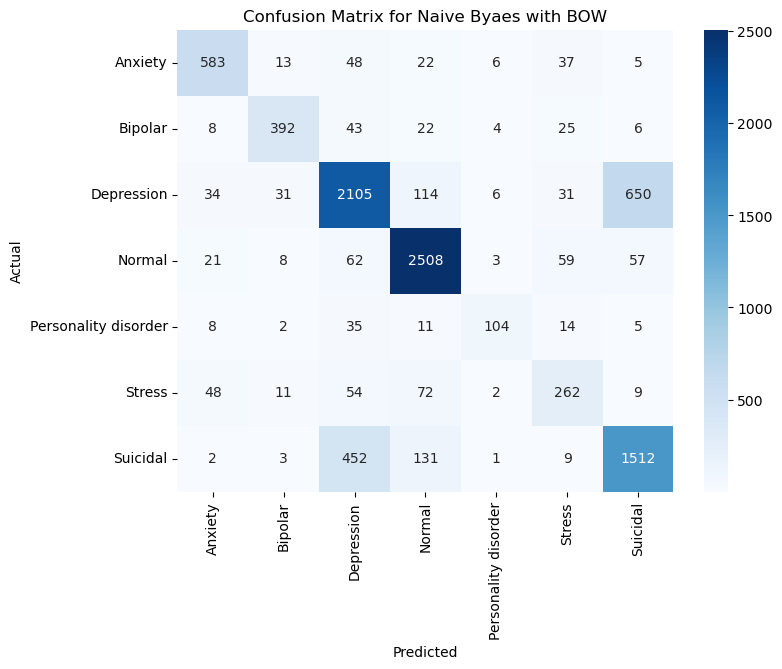

In [118]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Byaes with BOW')
plt.show()

### Class 3 - Normal 

**Precision: 0.87, Recall: 0.92, F1-Score: 0.90** <br>
The model performs best in distinguishing normal people from those diagnosed with a mental illness. 
This class has the highest recall, meaning the model correctly identifies most normal individuals as normal. 
Its precision is also high, indicating that very few people are mistakenly classified as normal despite having a mental illness.
Given its large support (2,718 instances), this performance positively impacts the overall accuracy.

### Class 0 - Anxiety

**Precision: 0.83, Recall: 0.82, F1-Score: 0.82** <br>
This class which is tagged as anxiety is well-balanced with both high precision and recall, indicating the model performs well 
in distinguishing this class without many false positives or false negatives.

### Class 1 - Bipolar

**Precision: 0.85, Recall: 0.78, F1-Score: 0.82** <br>
The Precision is high at 0.85, but recall is lower at 0.78 which shows that if someone does not have bipolar disorder 
there is a low chance that he/she will be identified as biploar by the model. But the model is not very good at capturing all
bipolars.

### Class 2 - Depression

**Precision: 0.75, Recall: 0.71, F1-Score: 0.73** <br>
The Depression class has the most instances (2971), but performance is moderate, with a precision of 0.75 
and a recall of 0.71. This indicates that the model is reasonably effective at detecting Depression but 
still misses 29% of actual cases and incorrectly labels some other classes as Depression 25% of the time. 
When we check the confusion matrix, we observe that the model has difficulty distinguishing between Depression 
and Suicidal. Considering that these conditions can overlap for some people, it is understandable why the model 
struggles to separate them more effectively.

### Class 4 - Personality Disorder

**Precision: 0.83, Recall: 0.58, F1-Score: 0.68** <br>
The model has a high precision (0.83) but a very low recall (0.58),
indicating that while it is usually correct when predicting Personality Disorder, 
it only identifies 58% of actual cases.
This suggests that many instances of Personality Disorder are being misclassified as other categories,
potentially due to insufficient or imbalanced data for this class. When we check the confusion matrix, we see that
                                                  most of the misclassifications are labeled as Depression.


### Class 6 - Suicidal

**Precision: 0.67, Recall: 0.72, F1-Score: 0.69** <br>
The precision (0.67) and recall (0.72) are relatively balanced but still leave room for improvement.
The model fails to detect about 28% ofSuicidal instances and misclassifies other categories as Suicidal 33% of the time.
When we check the confusion matrix, we see that most of the misclassifications are labeled as Depression or Normal.

### Class 5 - Stress

**Precision: 0.60, Recall: 0.57, F1-Score: 0.59** <br>
Both precision (0.60) and recall (0.57) are relatively low, indicating that the model struggles with accurately predicting Stress cases.
The low f1-score (0.59) suggests that there is significant confusion between Stress and other similar classes like Anxiety, Depression or Normal.

To enhance the model's performance, we will combine certain classes and observe how it affects the model's behavior.

## Combining Classes Anxiety with Stress, Depression with Suicidal

In [175]:
# Combine class 0 and 5 into one class, and 2 and 6 into another class
class_mapping = {
    0: 0, 5: 0,  # Combine classes 0 and 5 into class 0
    2: 2, 6: 2,  # Combine classes 2 and 6 into class 2
    1: 1,        # Keep class 1 as it is
    3: 3,        # Keep class 3 as it is
    4: 4         # Keep class 4 as it is
}

# Replace class labels in y
y_combined = data['status_encoded'].replace(class_mapping)

# Print the result to verify
print(y_combined.value_counts())  # See the distribution of new classes

status_encoded
2    25406
3    13590
0     5860
1     2501
4      892
Name: count, dtype: int64


In [179]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data[['statement','stemmed','stemmed word count','lemmatized']], y_combined, test_size=0.2, random_state=42,stratify = y_combined)

## TFIDF Vectorization

In [182]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2),min_df=10, stop_words='english')
X_train_tfidf2 = tfidf.fit_transform(X_train2['stemmed'])
X_test_tfidf2 = tfidf.transform(X_test2['stemmed'])

print('X_train_tfidf shape: ', X_train_tfidf2.shape)
print('X_test_tfidf shape: ', X_test_tfidf2.shape)

X_train_tfidf shape:  (38599, 5000)
X_test_tfidf shape:  (9650, 5000)


## Combining Word Length

In [186]:
# Ensure 'stemmed word count' is reshaped as a 2D array and convert it to sparse format
X_train_word_count2 = X_train2[['stemmed word count']].values
X_test_word_count2 = X_test2[['stemmed word count']].values

# Combine TF-IDF features with the stemmed word count feature
X_train_combined2 = hstack([X_train_tfidf2, X_train_word_count2])
X_test_combined2 = hstack([X_test_tfidf2, X_test_word_count2])

print('X_train_combined shape: ', X_train_combined2.shape)
print('X_test_combined shape: ', X_test_combined2.shape)

X_train_combined shape:  (38599, 5001)
X_test_combined shape:  (9650, 5001)


## Logistic Regression

In [188]:
log_reg_tfidf = LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
log_reg_tfidf.fit(X_train_combined2, y_train2)

y_pred = log_reg_tfidf.predict(X_test_combined2)
y_pred_train = log_reg_tfidf.predict(X_train_combined2)
print('Training Accuracy: ', round(accuracy_score(y_train2, y_pred_train),4))
print('Test Accuracy: ', round(accuracy_score(y_test2, y_pred),4))
print(classification_report(y_test2, y_pred))

Training Accuracy:  0.8989
Test Accuracy:  0.8638
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      1172
           1       0.73      0.81      0.77       500
           2       0.95      0.87      0.91      5081
           3       0.84      0.92      0.88      2718
           4       0.42      0.68      0.52       179

    accuracy                           0.86      9650
   macro avg       0.74      0.81      0.77      9650
weighted avg       0.88      0.86      0.87      9650



C:\Users\Betul\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Stacking Classifier

In [192]:
# Initialize the individual models
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs')
linear_svc = LinearSVC(C=0.2, class_weight='balanced', dual=False, loss='squared_hinge', max_iter=1000, penalty='l1')
nb = MultinomialNB(alpha=0.1, fit_prior=True)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=20, random_state=42, max_depth=30,
                            max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=500,max_samples=0.75)
xgb_clf = xgb.XGBClassifier(n_jobs=24, random_state=42, colsample_bytree=0.7, learning_rate=0.05, max_depth=4,
                            n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=1.0,gamma=0.1)

# Define the base models for stacking
estimators = [
    ('log_reg', log_reg),
    ('linear_svc', linear_svc),
    ('nb', nb),
    ('rf', rf),
    ('xgb', xgb_clf)
]

# The meta-classifier is now an XGBoost classifier
meta_classifier = xgb.XGBClassifier(
    n_jobs=20,
    random_state=42,
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=3,  # Use a simpler model for the meta-classifier
    n_estimators=100,
    reg_alpha=0.1,
    reg_lambda=1.0,
    subsample=0.75
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=cv,
    n_jobs=24
)

# Train the StackingClassifier
stacking_clf.fit(X_train_combined2, y_train2)

# Make predictions
y_pred = stacking_clf.predict(X_test_combined2)
y_pred_train = stacking_clf.predict(X_train_combined2)

# Evaluate the model
test_accuracy = accuracy_score(y_test2, y_pred)
train_accuracy = accuracy_score(y_train2, y_pred_train)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test2, y_pred))

Training Accuracy: 0.9282
Test Accuracy: 0.8939
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      1172
           1       0.86      0.76      0.81       500
           2       0.93      0.93      0.93      5081
           3       0.89      0.91      0.90      2718
           4       0.74      0.56      0.64       179

    accuracy                           0.89      9650
   macro avg       0.84      0.79      0.81      9650
weighted avg       0.89      0.89      0.89      9650



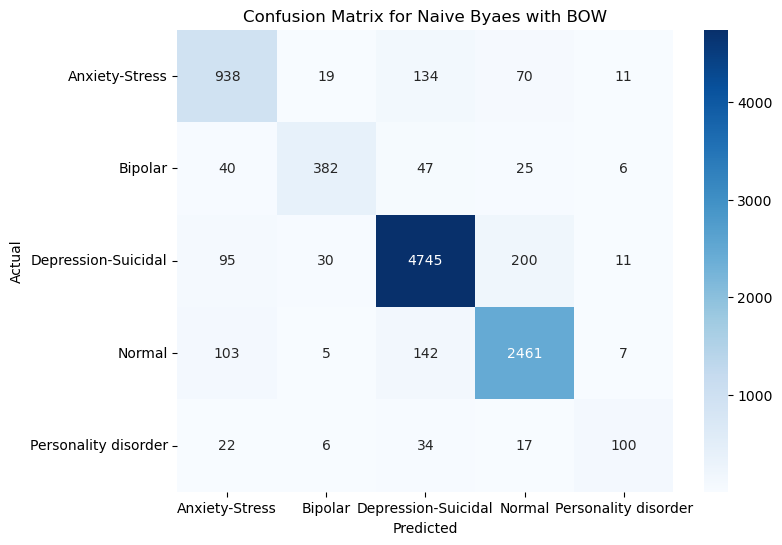

In [202]:
# Generate confusion matrix
cm = confusion_matrix(y_test2, y_pred)

class_names = np.array(['Anxiety-Stress', 'Bipolar', 'Depression-Suicidal', 'Normal',
                        'Personality disorder'], dtype=object)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Byaes with BOW')
plt.show()

In [204]:
# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation with shuffling

# Perform cross-validation
cv_scores = cross_val_score(stacking_clf, X_train_combined2, y_train2, cv=kf, scoring='accuracy', n_jobs=24)

# Print the cross-validation scores for each fold
print("Cross-Validation Scores for each fold:", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of Cross-Validation Accuracy: {np.std(cv_scores):.4f}")

Cross-Validation Scores for each fold: [0.89818653 0.89520725 0.89572539 0.89443005 0.89959839]
Mean Cross-Validation Accuracy: 0.8966
Standard Deviation of Cross-Validation Accuracy: 0.0019


## Drop Personality Disorder Which Has Small Number of INstances

In [207]:
# Create a new dataframe to keep the original data intact
data_modified = data.copy()

# Combine class 0 and 5 into one class, and 2 and 6 into another class
class_mapping = {
    0: 0, 5: 0,  # Combine classes 0 and 5 into class 0
    2: 2, 6: 2,  # Combine classes 2 and 6 into class 2
    1: 1,        # Keep class 1 as it is
    3: 3,        # Keep class 3 as it is
    4: 4         # Keep class 4 as it is for now
}

# Replace class labels in the new dataframe
data_modified['status_combined'] = data_modified['status_encoded'].replace(class_mapping)

# Drop rows where the class is 4 from the new dataframe
data_filtered = data_modified[data_modified['status_combined'] != 4]

# Print the distribution of the new classes
print(data_filtered['status_combined'].value_counts())

status_combined
2    25406
3    13590
0     5860
1     2501
Name: count, dtype: int64


In [221]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(data_filtered[['statement','stemmed','stemmed word count','lemmatized']], data_filtered['status_combined'], test_size=0.2, random_state=42,stratify = data_filtered['status_combined'])

In [223]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2),min_df=10, stop_words='english')
X_train_tfidf3 = tfidf.fit_transform(X_train3['stemmed'])
X_test_tfidf3 = tfidf.transform(X_test3['stemmed'])

print('X_train_tfidf shape: ', X_train_tfidf3.shape)
print('X_test_tfidf shape: ', X_test_tfidf3.shape)

X_train_tfidf shape:  (37885, 5000)
X_test_tfidf shape:  (9472, 5000)


In [225]:
# Ensure 'stemmed word count' is reshaped as a 2D array and convert it to sparse format
X_train_word_count3 = X_train3[['stemmed word count']].values
X_test_word_count3 = X_test3[['stemmed word count']].values

# Combine TF-IDF features with the stemmed word count feature
X_train_combined3 = hstack([X_train_tfidf3, X_train_word_count3])
X_test_combined3 = hstack([X_test_tfidf3, X_test_word_count3])

print('X_train_combined shape: ', X_train_combined3.shape)
print('X_test_combined shape: ', X_test_combined3.shape)

X_train_combined shape:  (37885, 5001)
X_test_combined shape:  (9472, 5001)


In [227]:
# Initialize the individual models
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs')
linear_svc = LinearSVC(C=0.2, class_weight='balanced', dual=False, loss='squared_hinge', max_iter=1000, penalty='l1')
nb = MultinomialNB(alpha=0.1, fit_prior=True)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=20, random_state=42, max_depth=30,
                            max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=500,max_samples=0.75)
xgb_clf = xgb.XGBClassifier(n_jobs=24, random_state=42, colsample_bytree=0.7, learning_rate=0.05, max_depth=4,
                            n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=1.0,gamma=0.1)

# Define the base models for stacking
estimators = [
    ('log_reg', log_reg),
    ('linear_svc', linear_svc),
    ('nb', nb),
    ('rf', rf),
    ('xgb', xgb_clf)
]

# The meta-classifier is now an XGBoost classifier
meta_classifier = xgb.XGBClassifier(
    n_jobs=20,
    random_state=42,
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=3,  # Use a simpler model for the meta-classifier
    n_estimators=100,
    reg_alpha=0.1,
    reg_lambda=1.0,
    subsample=0.75
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=cv,
    n_jobs=24
)

# Train the StackingClassifier
stacking_clf.fit(X_train_combined3, y_train3)

# Make predictions
y_pred = stacking_clf.predict(X_test_combined3)
y_pred_train = stacking_clf.predict(X_train_combined3)

# Evaluate the model
test_accuracy = accuracy_score(y_test3, y_pred)
train_accuracy = accuracy_score(y_train3, y_pred_train)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test3, y_pred))

Training Accuracy: 0.9311
Test Accuracy: 0.9017
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1172
           1       0.87      0.77      0.82       500
           2       0.93      0.93      0.93      5082
           3       0.89      0.91      0.90      2718

    accuracy                           0.90      9472
   macro avg       0.87      0.85      0.86      9472
weighted avg       0.90      0.90      0.90      9472



## Drop Personality Disorder and Stress, Combine Depression and Suicidal

Personality Disorder and Stress have a small number of instances in the dataset, so we will drop them. Depression and Suicidal share overlapping characteristics, so we will combine them into one class.

In [248]:
# Create a new dataframe to keep the original data intact
data_modified2 = data.copy()

# Combine class 0 and 5 into one class, and 2 and 6 into another class
class_mapping = {
    0: 0,  # Keep class 0 as it is
    2: 2, 6: 2,  # Combine classes 2 and 6 into class 2
    1: 1,        # Keep class 1 as it is
    3: 3,        # Keep class 3 as it is
    4: 4,         # Keep class 4 as it is for now
    5:5    # Keep class 5 as it is for now
}

# Replace class labels in the new dataframe
data_modified2['status_combined'] = data_modified2['status_encoded'].replace(class_mapping)

# Drop rows where the class is 4,5 from the new dataframe
data_filtered2 = data_modified2[(data_modified2['status_combined'] != 4) & (data_modified2['status_combined'] != 5)]

# Print the distribution of the new classes
print(data_filtered2['status_combined'].value_counts())

status_combined
2    25406
3    13590
0     3571
1     2501
Name: count, dtype: int64


In [252]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(data_filtered2[['statement','stemmed','stemmed word count','lemmatized']], data_filtered2['status_combined'], test_size=0.2, random_state=42,stratify = data_filtered2['status_combined'])

In [254]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2),min_df=10, stop_words='english')
X_train_tfidf4 = tfidf.fit_transform(X_train4['stemmed'])
X_test_tfidf4 = tfidf.transform(X_test4['stemmed'])

print('X_train_tfidf shape: ', X_train_tfidf4.shape)
print('X_test_tfidf shape: ', X_test_tfidf4.shape)

X_train_tfidf shape:  (36054, 5000)
X_test_tfidf shape:  (9014, 5000)


In [256]:
# Ensure 'stemmed word count' is reshaped as a 2D array and convert it to sparse format
X_train_word_count4 = X_train4[['stemmed word count']].values
X_test_word_count4 = X_test4[['stemmed word count']].values

# Combine TF-IDF features with the stemmed word count feature
X_train_combined4 = hstack([X_train_tfidf4, X_train_word_count4])
X_test_combined4 = hstack([X_test_tfidf4, X_test_word_count4])

print('X_train_combined shape: ', X_train_combined4.shape)
print('X_test_combined shape: ', X_test_combined4.shape)

X_train_combined shape:  (36054, 5001)
X_test_combined shape:  (9014, 5001)


In [258]:
# Initialize the individual models
log_reg = LogisticRegression(max_iter=10000, class_weight='balanced', solver='lbfgs')
linear_svc = LinearSVC(C=0.2, class_weight='balanced', dual=False, loss='squared_hinge', max_iter=1000, penalty='l1')
nb = MultinomialNB(alpha=0.1, fit_prior=True)
rf = RandomForestClassifier(class_weight='balanced', n_jobs=20, random_state=42, max_depth=30,
                            max_features='sqrt', min_samples_leaf=2, min_samples_split=5, n_estimators=500,max_samples=0.75)
xgb_clf = xgb.XGBClassifier(n_jobs=24, random_state=42, colsample_bytree=0.7, learning_rate=0.05, max_depth=4,
                            n_estimators=500, reg_alpha=1.0, reg_lambda=0.5, subsample=1.0,gamma=0.1)

# Define the base models for stacking
estimators = [
    ('log_reg', log_reg),
    ('linear_svc', linear_svc),
    ('nb', nb),
    ('rf', rf),
    ('xgb', xgb_clf)
]

# The meta-classifier is now an XGBoost classifier
meta_classifier = xgb.XGBClassifier(
    n_jobs=20,
    random_state=42,
    colsample_bytree=0.6,
    learning_rate=0.1,
    max_depth=3,  # Use a simpler model for the meta-classifier
    n_estimators=100,
    reg_alpha=0.1,
    reg_lambda=1.0,
    subsample=0.75
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create the StackingClassifier
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=meta_classifier,
    cv=cv,
    n_jobs=24
)

# Train the StackingClassifier
stacking_clf.fit(X_train_combined4, y_train4)

# Make predictions
y_pred = stacking_clf.predict(X_test_combined4)
y_pred_train = stacking_clf.predict(X_train_combined4)

# Evaluate the model
test_accuracy = accuracy_score(y_test4, y_pred)
train_accuracy = accuracy_score(y_train4, y_pred_train)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test4, y_pred))

Training Accuracy: 0.9435
Test Accuracy: 0.9239
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       714
           1       0.88      0.78      0.83       500
           2       0.94      0.95      0.94      5082
           3       0.91      0.92      0.92      2718

    accuracy                           0.92      9014
   macro avg       0.90      0.88      0.89      9014
weighted avg       0.92      0.92      0.92      9014



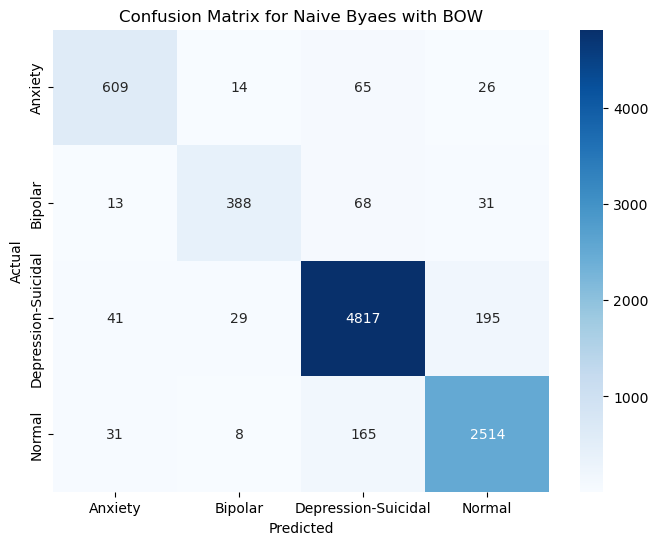

In [275]:
# Generate confusion matrix
cm = confusion_matrix(y_test4, y_pred)

class_names = np.array(['Anxiety', 'Bipolar', 'Depression-Suicidal', 'Normal'], dtype=object)
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Byaes with BOW')
plt.show()

## Cross Validation Analysis

In [278]:
# Initialize K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation with shuffling

# Perform cross-validation
cv_scores = cross_val_score(stacking_clf, X_train_combined4, y_train4, cv=kf, scoring='accuracy', n_jobs=24)

# Print the cross-validation scores for each fold
print("Cross-Validation Scores for each fold:", cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation of Cross-Validation Accuracy: {np.std(cv_scores):.4f}")

Cross-Validation Scores for each fold: [0.9191513  0.92372764 0.92469838 0.91845791 0.92801664]
Mean Cross-Validation Accuracy: 0.9228
Standard Deviation of Cross-Validation Accuracy: 0.0036


By dropping classes with few instances and combining those with overlapping characteristics, we increased the accuracy to over 92%. The cross-validation results are consistent across different training sets, which is encouraging.

## Training Time

The training time for the best model, Stacking Classifier is around 20-30 minutes. 